# GOTO-tile examples

---
## The SkyMap class

The `gototile.skymap` module contains the `SkyMap` class, which can be used to handle skymaps from GW detectors or other sources.

In [18]:
from gototile.skymap import SkyMap

The `SkyMap` class is best created using one of the following class methods:
* `SkyMap.from_fits(file)` takes any string that can be passed to `astropy.io.fits.open`, which can include a local path or a URL, or an `astropy.io.fits.HDU` if the file is already open.
* `SkyMap.from_position(ra, dec, radius, nside=64)` creates a Gaussian skymap with the given radius at the given coordinates. The `nside` resolution parameter must be a power of 2.

Here we will initiate a SkyMap using a real LIGO/Virgo gravitational-wave detection map, for event **S190521r**:

In [19]:
url = 'https://gracedb.ligo.org/api/superevents/S190521r/files/bayestar.fits.gz'
skymap = SkyMap.from_fits(url)

It's that simple.

The skymap probability information is stored within the `SkyMap.data` array, with each entry being the probability assigned to that HEALPix pixel.

In [20]:
print(f'Skymap data (len={len(skymap.data)}):')
print(skymap.data)

Skymap data (len=3145728):
[1.65062477e-39 1.65062477e-39 1.65062477e-39 ... 1.03124654e-30
 1.03124654e-30 1.03124654e-30]


 The `SkyMap.nside` property gives the HEALPix resolution. Note this is a very high resolution map with over 3 million pixels, each individual pixel covers a small fraction of the sky (as above, the localisation probability in the first few pixels is ~1 in 10^-40!). Overall the skymap is normalised, so the entire probability adds to 1 (or near enough).

In [21]:
print('Npix:', skymap.npix)
print('Nside:', skymap.nside)
print(f'Pixel area: {skymap.pixel_area:.3f} deg2 ({skymap.pixel_area*3600:.1f} arcmin2)')

print(f'Min pixel probability: {min(skymap.data):.2e}')
print(f'Max pixel probability: {max(skymap.data):.2e}')
print(f'Total skymap probability: {sum(skymap.data)}')

Npix: 3145728
Nside: 512
Pixel area: 0.013 deg2 (47.2 arcmin2)
Min pixel probability: 1.16e-81
Max pixel probability: 6.11e-05
Total skymap probability: 0.9999999999994725


The `SkyMap` class also has a useful `.plot()` method, so we can see what the skymap actually looks like:

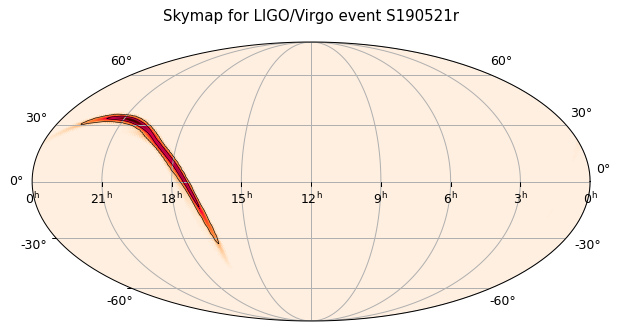

In [22]:
skymap.plot(title='Skymap for LIGO/Virgo event S190521r')

### Multi-order skymaps

The skymap we've been using is "flat", i.e. its pixels are at the same resolution across the entire sphere. That's incredibly inefficient for this sort of data, where an awful lot of the pixels away from the peak will essentially have a value of zero.

To better compress these sorts of skymaps there is an alternative HEALPix ordering method: `NUNIQ`, which produces a multi-order coverage (MOC) map. GOTO-tile can also read these maps, so let's load the multi-order map for the same map.

In [23]:
url_moc = 'https://gracedb.ligo.org/api/superevents/S190521r/files/GW190521_074359_PublicationSamples.multiorder.fits'
skymap_moc = SkyMap.from_fits(url_moc)

Here the number of pixels has been greatly reduced, because instead of the same resolution across the sphere different pixels now have different areas.

In [24]:
print('Npix:', skymap_moc.npix)

Npix: 16896


We can see the changing resolutions by plotting the pixels, it's clear that the regions of high probability have a higher pixel resolution while the low-probability areas do not need the same number of pixels. 

**Warning: this plot can take several minutes to generate.**

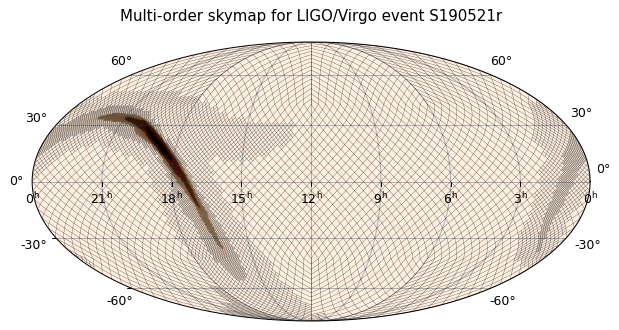

In [25]:
skymap_moc.plot(title='Multi-order skymap for LIGO/Virgo event S190521r',
                plot_contours=False,
                plot_pixels=True)

We can also zoom in on the peak of the probability to see the different resolutions. To do this we find the index of the pixel at the peak of the distribution, then centre on those coordinates.

**Warning: this plot can take several minutes to generate.**

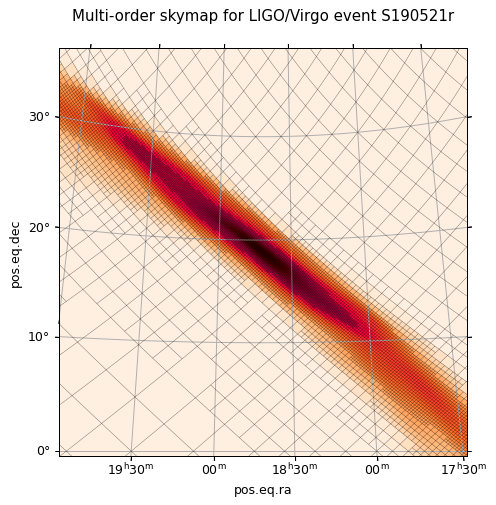

In [26]:
import numpy as np

max_ipix = np.where(skymap_moc.data == max(skymap_moc.data))[0][0]
max_coords = skymap_moc.coords[max_ipix]

skymap_moc.plot(title='Multi-order skymap for LIGO/Virgo event S190521r',
                plot_contours=False,
                plot_pixels=True,
                plot_type='zoom',
                center=max_coords,
                radius=20)

It's also worth mentioning that the skymap data is now given in units of probability density (probability per steradian) instead of just probability. You can convert between the two easily, if for instance you want to find the total probability within a given area (which we do when applying the skymap to a grid, see below).

Note how after converting the copy now sums to unity (well, almost), which is what you'd expect of a probability map.

In [27]:
print('Is this a density map?', skymap_moc.density)
print('Pixel sum:', sum(skymap_moc.data))

skymap_moc_copy = skymap_moc.copy()
skymap_moc_copy.density = False

print('Is this a density map?', skymap_moc_copy.density)
print('Pixel sum:', sum(skymap_moc_copy.data))


Is this a density map? True
Pixel sum: 102613.9859647357
Is this a density map? True
Pixel sum: 0.9999999999999962


Note that plotting the skymap after converting to density looks rather strange and jagged, since the pixels are different shapes and therefore the colormap isn't the best way to display the data. It's better to either convert to a flat map or back to probability density before plotting.

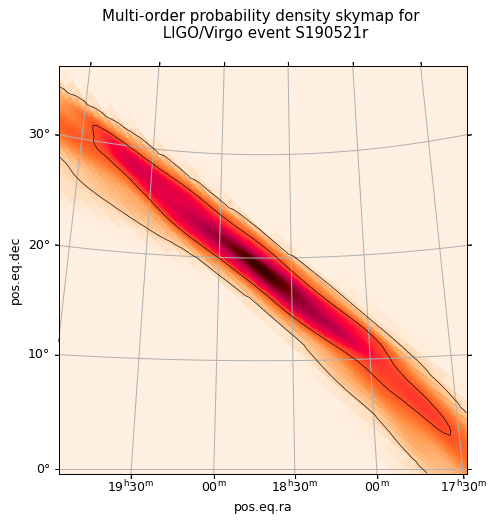

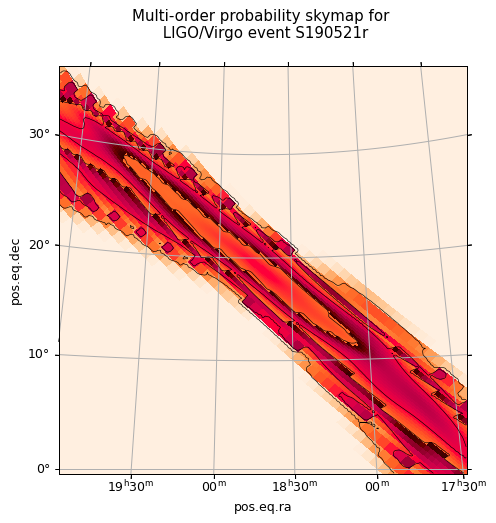

In [28]:
skymap_moc.plot(title='Multi-order probability density skymap for \n LIGO/Virgo event S190521r',
                plot_type='zoom',
                center=max_coords,
                radius=20)

skymap_moc_copy.plot(title='Multi-order probability skymap for \n LIGO/Virgo event S190521r',
                     plot_type='zoom',
                     center=max_coords,
                     radius=20)

---
## The SkyGrid class

The `gototile.grid` module contains the `SkyGrid` class, which can be used to create a regular grid of tiles in the sky for survey telescopes (such as GOTO).

In [29]:
from gototile.grid import SkyGrid

The `SkyGrid` class takes two parameters: the field of view of a tile (in RA and Dec) and the desired overlap between tiles in both axes (as a fraction: 0 is no overlap, 0.5 is overlapping half of each tile). Here we will use the parameters used by the GOTO-4 prototype: a tile of 3.7x4.9 degrees, with 10 % overlap in both axes.

In [30]:
grid = SkyGrid((3.7, 4.9), (0.1, 0.1))
grid

SkyGrid(fov=(3.7, 4.9), overlap=(0.1, 0.1), kind=minverlap)

Alternatively, since the package was created for GOTO several named grids are also pre-defined - including the GOTO-4 grid. This saves having to remember the above numbers every time:

In [31]:
grid = SkyGrid.from_name('GOTO-4')
grid

SkyGrid(fov=(3.7, 4.9), overlap=(0.1, 0.1), kind=minverlap)

Don't worry about the "kind" parameter here, it's related to the particular gridding function used to generate the array of tiles. The "minverlap" algorithm was used during the GOTO-4 prototype period, so it's selected here. See `gototile.gridtools` for more grid functions.

Useful properties include the number of tiles, the central coordinates of each (as a 1-D Astropy `SkyCoord`) and the tile name given to each (a 1-indexed string in the form `T1234`). Note that tiles are numbered in increasing Dec and RA, so tile `T0001` is on the south pole.

In [32]:
print('Ntiles:', grid.ntiles)
for name, coord in zip(grid.tilenames, grid.coords):
    print(name, coord.to_string('hmsdms'))
    if name == 'T0015':
        # Stop after the first 15 tiles
        print('...')
        break

Ntiles: 2913
T0001 00h00m00s -90d00m00s
T0002 00h00m00s -85d42m51.4286s
T0003 02h40m00s -85d42m51.4286s
T0004 05h20m00s -85d42m51.4286s
T0005 08h00m00s -85d42m51.4286s
T0006 10h40m00s -85d42m51.4286s
T0007 13h20m00s -85d42m51.4286s
T0008 16h00m00s -85d42m51.4286s
T0009 18h40m00s -85d42m51.4286s
T0010 21h20m00s -85d42m51.4286s
T0011 00h00m00s -81d25m42.8571s
T0012 01h24m42.3529s -81d25m42.8571s
T0013 02h49m24.7059s -81d25m42.8571s
T0014 04h14m07.0588s -81d25m42.8571s
T0015 05h38m49.4118s -81d25m42.8571s
...


As before the class has a convenient `.plot()` method, to visualise the celestial sphere covered in tiles:

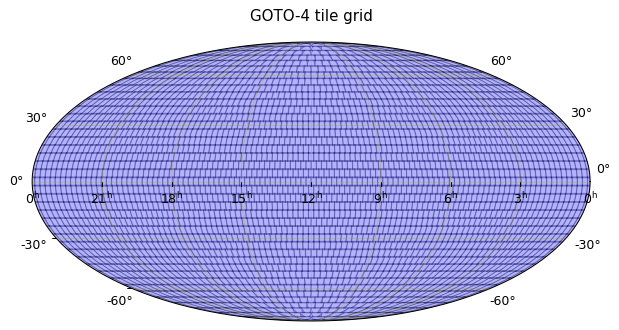

In [33]:
grid.plot(title='GOTO-4 tile grid')

---
## Applying SkyMaps to SkyGrids

The real power of the above two classes arises when they are used together. "Applying" a probability skymap to a grid involves calculating the contained probability within each grid tile, and is easily done using the `SkyGrid.apply_skymap()` method:

In [34]:
grid.apply_skymap(skymap)

array([2.06121812e-05, 4.01245197e-05, 1.99343331e-05, ...,
       9.00334600e-49, 6.98056461e-48, 1.66855505e-47])

The above function returned the probability contained within each grid tile, this is also saved as `SkyMap.probs`. An easy way to find which tiles contain the most probability is to use the `SkyMap.get_table()` method, which returns an Astropy QTable.

In [35]:
table = grid.get_table()
table.sort('prob')
table.reverse()
print(table)

tilename         ra                dec                  prob         
                deg                deg                               
-------- ------------------ ------------------ ----------------------
   T2214 298.72340425531917 29.999999999999915    0.04340928171083684
   T2215  302.5531914893617 29.999999999999915   0.042520015182819317
   T2308              312.0  34.28571428571421    0.04220410690918048
   T1700  269.1588785046729  8.571428571428456    0.04164115494002285
   T1482 260.91743119266056                0.0    0.04091929680952511
   T2309              316.0  34.28571428571421   0.040226249442311415
   T2117  290.2040816326531 25.714285714285623    0.03681466369983706
   T2017  285.1485148514852  21.42857142857133    0.03659670864037186
   T2307              308.0  34.28571428571421    0.03652774303301416
   T1591 263.33333333333337  4.285714285714164   0.035705124811035174
     ...                ...                ...                    ...
   T2361 173.6470588

As you can see, tile `T2214` has the highest contained probability (4.34%).

The probability contained within each tile can also be plotted on the grid:

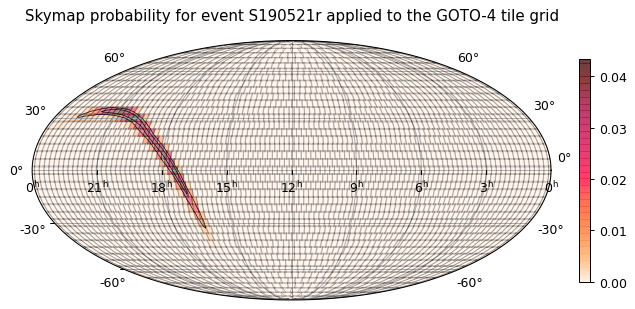

In [36]:
grid.plot(title='Skymap probability for event S190521r applied to the GOTO-4 tile grid',
          plot_skymap=True,
          plot_contours=True)

Note that since there will always be some overlap between tiles the total probability will sum to more than one (as we are double-counting any probability contained within multiple tiles) - in this case the total sum comes to ~137%.

In [37]:
print(f'Total probability in all tiles: {sum(grid.probs)}')

Total probability in all tiles: 1.3681691447121054


The overlap between tiles be seen clearly with a more zoomed-in plot, which we can centre on the highest-probability tile:

The highest probability tile is T2214 containing 4.341%, centred on 19h54m53.617s +30d00m00s.


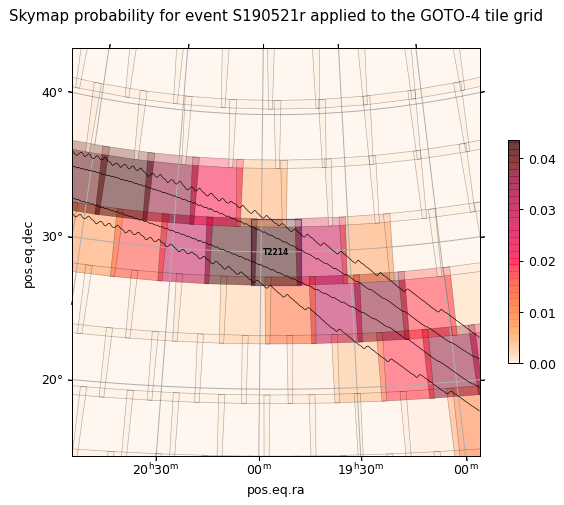

In [38]:
high_tile_index = np.where(grid.probs == max(grid.probs))[0][0]
high_tile_name = grid.tilenames[high_tile_index]
high_tile_coord = grid.coords[high_tile_index]
print(f'The highest probability tile is {high_tile_name} containing {max(grid.probs):.3%}, centred on {high_tile_coord.to_string("hmsdms")}.')

grid.plot(title='Skymap probability for event S190521r applied to the GOTO-4 tile grid',
          plot_skymap=True,
          plot_contours=True,
          plot_type='zoom',
          center=high_tile_coord,
          radius=15,
          tilenames=[high_tile_name],
          highlight=[high_tile_name])

This can be annoying when considering the total probability within overlapping tiles. For instance tile `T2214` contains the highest probability and `T2215`, the tile immediately to the left on the plot above, contains the second highest. Since they overlap the probability within their combined area will be less than the sum of both probabilities. This is where the `SkyGrid.get_probability()` method is useful, as it will only count for any HEALPix pixels contained within the combined area once.

In [39]:
tiles = ['T2214', 'T2215']
for tile in tiles:
    print(f'Probability within tile {tile}: {grid.get_probability(tile):.3%}')
print(f'Probability sum (not accounting for overlap): {sum([grid.get_probability(tile) for tile in tiles]):.3%}')
print(f'Probability within total area (accounting for overlap): {grid.get_probability(tiles):.3%}')

Probability within tile T2214: 4.341%
Probability within tile T2215: 4.252%
Probability sum (not accounting for overlap): 8.593%
Probability within total area (accounting for overlap): 7.941%
